In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df_crawled_graphic = pd.read_excel('./drive/MyDrive/Colab Notebooks/Design - AI//re_original data.xlsx', sheet_name='graphic')
df_crawled_industry = pd.read_excel('./drive/MyDrive/Colab Notebooks/Design - AI//re_original data.xlsx', sheet_name='industry')
df_crawled_ux = pd.read_excel('./drive/MyDrive/Colab Notebooks/Design - AI//re_original data.xlsx', sheet_name='ux')
df_crawled_fashion = pd.read_excel('./drive/MyDrive/Colab Notebooks/Design - AI//re_original data.xlsx', sheet_name='fashion')

In [3]:
df_crawled_graphic['contents'] = df_crawled_graphic['contents'].fillna(' ')
df_crawled_industry['contents'] = df_crawled_industry['contents'].fillna(' ')
df_crawled_ux['contents'] = df_crawled_ux['contents'].fillna(' ')
df_crawled_fashion['contents'] = df_crawled_fashion['contents'].fillna(' ')

df_crawled_graphic['contents'] = df_crawled_graphic['contents'].str.replace(r'[^a-zA-Z]',' ', regex=True)
df_crawled_industry['contents'] = df_crawled_industry['contents'].str.replace(r'[^a-zA-Z]',' ', regex=True)
df_crawled_ux['contents'] = df_crawled_ux['contents'].str.replace(r'[^a-zA-Z]',' ', regex=True)
df_crawled_fashion['contents'] = df_crawled_fashion['contents'].str.replace(r'[^a-zA-Z]',' ', regex=True)

df_crawled_graphic['contents'] = df_crawled_graphic['contents'].str.lower()
df_crawled_industry['contents'] = df_crawled_industry['contents'].str.lower()
df_crawled_ux['contents'] = df_crawled_ux['contents'].str.lower()
df_crawled_fashion['contents'] = df_crawled_fashion['contents'].str.lower()

df_crawled_graphic['contents'] = df_crawled_graphic['contents'].str.replace("'", '')
df_crawled_industry['contents'] = df_crawled_industry['contents'].str.replace("'", '')
df_crawled_ux['contents'] = df_crawled_ux['contents'].str.replace("'", '')
df_crawled_fashion['contents'] = df_crawled_fashion['contents'].str.replace("'", '')

In [4]:
df_crawled_graphic.reset_index(inplace=True)
df_crawled_industry.reset_index(inplace=True)
df_crawled_ux.reset_index(inplace=True)
df_crawled_fashion.reset_index(inplace=True)

df_crawled_graphic.rename(columns={'index': 'ID'}, inplace=True)
df_crawled_industry.rename(columns={'index': 'ID'}, inplace=True)
df_crawled_ux.rename(columns={'index': 'ID'}, inplace=True)
df_crawled_fashion.rename(columns={'index': 'ID'}, inplace=True)

In [5]:
print(len(df_crawled_graphic))
print(len(df_crawled_industry))
print(len(df_crawled_ux))
print(len(df_crawled_fashion))

2103
1603
2397
1494


In [6]:
df_crawled_combined = pd.concat([df_crawled_graphic,df_crawled_industry,df_crawled_ux,df_crawled_fashion], join='outer', axis=0, ignore_index=True)

In [7]:
df_crawled_combined

,ID,contents
0,0,how is ai used in graphic design
1,1,graphic design is one of the fields that has b...
2,2,
3,3,ai tools help to create graphics improve qual...
4,4,
...,...,...
7592,1489,in summary
7593,1490,
7594,1491,the fashion industry holds a bright future ahe...
7595,1492,


---

In [ ]:
import nltk
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# NLTK의 불용어 다운로드
nltk.download('stopwords')

# 불용어 리스트 로드
stop_words = set(stopwords.words('english'))  # 영어 불용어 리스트를 사용할 경우

# 각 문장에서 불용어 제거하는 함수 정의
def remove_stopwords(sentence):
    words = sentence.split()  # 문장을 단어로 분할
    filtered_words = [word for word in words if word.lower() not in stop_words]  # 불용어가 아닌 단어만 필터링
    return ' '.join(filtered_words)  # 필터링된 단어들을 다시 문장으로 합치기

# 각 행의 문장에서 불용어 제거하기
df_crawled_combined['contents'] = df_crawled_combined['contents'].apply(remove_stopwords)

In [ ]:
df_crawled_combined

,ID,contents
0,0,ai used graphic design
1,1,graphic design one fields impacted development...
2,2,
3,3,ai tools help create graphics improve quality ...
4,4,
...,...,...
7592,1489,summary
7593,1490,
7594,1491,fashion industry holds bright future ahead exp...
7595,1492,


---

In [ ]:
from gensim import corpora
from gensim.models import LdaModel
from pprint import pprint

In [ ]:
# 텍스트 전처리 및 토큰화
texts = [text.lower().split() for text in df_crawled_combined['contents']]

# 단어 사전 생성
dictionary = corpora.Dictionary(texts)

# 문서-단어 행렬 생성
corpus = [dictionary.doc2bow(text) for text in texts]

# LDA 모델 학습
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# 문서별 주제 분포 출력
for i, doc in enumerate(corpus):
    print("문서 {}의 주제 분포: {}".format(i, lda_model.get_document_topics(doc)))

In [ ]:
# 학습된 주제 및 상위 단어 출력
topics = lda_model.print_topics(num_words=30)
for topic in topics:
    print(topic)

(0, '0.016*"fashion" + 0.013*"images" + 0.012*"image" + 0.012*"model" + 0.010*"color" + 0.010*"ai" + 0.009*"style" + 0.008*"based" + 0.007*"text" + 0.007*"like" + 0.007*"generate" + 0.006*"create" + 0.006*"aida" + 0.006*"models" + 0.005*"e" + 0.005*"example" + 0.005*"designer" + 0.005*"generative" + 0.005*"brand" + 0.005*"pattern" + 0.005*"generated" + 0.005*"using" + 0.005*"developed" + 0.005*"use" + 0.004*"system" + 0.004*"tool" + 0.004*"uses" + 0.004*"dall" + 0.004*"used" + 0.004*"could"')
(1, '0.045*"ai" + 0.028*"fashion" + 0.017*"user" + 0.016*"design" + 0.011*"data" + 0.011*"create" + 0.009*"product" + 0.008*"customer" + 0.008*"designs" + 0.008*"designers" + 0.007*"preferences" + 0.007*"help" + 0.006*"experience" + 0.006*"industry" + 0.006*"clothing" + 0.006*"algorithms" + 0.005*"tools" + 0.005*"technology" + 0.005*"digital" + 0.005*"products" + 0.005*"generative" + 0.005*"virtual" + 0.005*"also" + 0.005*"experiences" + 0.005*"learning" + 0.005*"personalized" + 0.005*"trends" + 0

In [ ]:
# 각 주제별로 가장 높은 점수를 가진 문장 5개씩 출력
def get_top_sentences(lda_model, corpus, texts, num_sentences=10):
    top_sentences = {}
    for i, topic in lda_model.show_topics(num_topics=-1, formatted=False):
        sorted_topic = sorted(topic, key=lambda x: x[1], reverse=True)
        top_words = [word[0] for word in sorted_topic[:5]]  # 상위 5개 단어 선택
        top_sentences[i] = []
        for j, doc in enumerate(lda_model[corpus]):
            for score in doc:
                if score[0] == i:
                    top_sentences[i].append((score[1], ' '.join(texts[j])))
        top_sentences[i] = sorted(top_sentences[i], key=lambda x: x[0], reverse=True)[:num_sentences]
    return top_sentences

top_sentences = get_top_sentences(lda_model, corpus, texts)
for i in range(len(top_sentences)):
    print("주제 {}:".format(i))
    for score, sentence in top_sentences[i]:
        print("스코어 - {:.4f}, 문장: {}".format(score, sentence))
    print()

---

In [8]:
df_abcd = pd.read_excel('./drive/MyDrive/Colab Notebooks/Design - AI/re7_keyword.xlsx', header=[0])

df_abcd_m = df_abcd.melt()
df_abcd_m.dropna(axis=0, subset=['value'], how='any', inplace=True)



df_abcd_lst = df_abcd.columns.to_list()

In [9]:
def gen_document(ID, word_lst):
    df_tmp = pd.DataFrame(
        {
            'ID'       : ID,
            'sentence' : word_lst
        }
    )
    return df_tmp

def gen_DataFrame(df):
    df_res = pd.DataFrame()
    for i, row in enumerate(df.itertuples()):
        word_lst = row.contents.split()
        df_doc = gen_document(row.ID, word_lst)
        df_res = pd.concat([df_res, df_doc])
    df_res.reset_index(inplace=True)
    df_res.drop('index', axis=1, inplace=True)

    return df_res

df_crawled_graphic_k = gen_DataFrame(df_crawled_graphic)
df_crawled_industry_k = gen_DataFrame(df_crawled_industry)
df_crawled_ux_k = gen_DataFrame(df_crawled_ux)
df_crawled_fashion_k = gen_DataFrame(df_crawled_fashion)

In [10]:
df_crawled_graphic_k

,ID,sentence
0,0,how
1,0,is
2,0,ai
3,0,used
4,0,in
...,...,...
39285,2102,boundaries
39286,2102,of
39287,2102,traditional
39288,2102,graphic


In [11]:
def get_frequency(df_con):
    sentences1 = df_con['sentence'].tolist()
    sentences2 = df_abcd_m['value'].tolist()
    ar_freq = np.zeros((len(sentences1), len(sentences2)))
    for i in range(ar_freq.shape[0]):
        for j in range(ar_freq.shape[1]):
            if sentences1[i] == sentences2[j]:
                ar_freq[i, j] = 1.0
    return ar_freq

freq_array_graphic = get_frequency(df_crawled_graphic_k)
freq_array_industry = get_frequency(df_crawled_industry_k)
freq_array_ux = get_frequency(df_crawled_ux_k)
freq_array_fashion = get_frequency(df_crawled_fashion_k)

In [12]:
print(freq_array_graphic.shape)
print(freq_array_industry.shape)
print(freq_array_ux.shape)
print(freq_array_fashion.shape)

(39290, 80)
(33268, 80)
(36751, 80)
(28887, 80)


In [13]:
sr_abcd = df_abcd.count()



def set_score(freq_array, df_con):
    sr_abcd = df_abcd.count()
    for key in sr_abcd.index:
        df_con[key] = 0.0
    for idx in df_con.index:
        off_b = 0
        off_e = 0
        for key in sr_abcd.index:
            off_b = off_e
            off_e += sr_abcd[key]
            df_con.loc[idx, key] = freq_array[idx][off_b:off_e].sum()
        if idx % 1000 == 0:
            print('<cnt:{}, idx:{}> ======================'.format(idx//1000,idx))
    print(' === End of job === ')
    return df_con


df_crawled_graphic_k = set_score(freq_array_graphic, df_crawled_graphic_k)

df_crawled_industry_k = set_score(freq_array_industry, df_crawled_industry_k)

df_crawled_ux_k = set_score(freq_array_ux, df_crawled_ux_k)

df_crawled_fashion_k = set_score(freq_array_fashion, df_crawled_fashion_k)

<cnt:0, idx:0> ======================
<cnt:1, idx:1000> ======================
<cnt:2, idx:2000> ======================
<cnt:3, idx:3000> ======================
<cnt:4, idx:4000> ======================
<cnt:5, idx:5000> ======================
<cnt:6, idx:6000> ======================
<cnt:7, idx:7000> ======================
<cnt:8, idx:8000> ======================
<cnt:9, idx:9000> ======================
<cnt:10, idx:10000> ======================
<cnt:11, idx:11000> ======================
<cnt:12, idx:12000> ======================
<cnt:13, idx:13000> ======================
<cnt:14, idx:14000> ======================
<cnt:15, idx:15000> ======================
<cnt:16, idx:16000> ======================
<cnt:17, idx:17000> ======================
<cnt:18, idx:18000> ======================
<cnt:19, idx:19000> ======================
<cnt:20, idx:20000> ======================
<cnt:21, idx:21000> ======================
<cnt:22, idx:22000> ======================
<cnt:23, idx:23000> ==============

In [14]:
df_crawled_graphic_k.to_pickle('./freq_result_graphic')
df_crawled_industry_k.to_pickle('./freq_result_industry')
df_crawled_ux_k.to_pickle('./freq_result_ux')
df_crawled_fashion_k.to_pickle('./freq_result_fashion')

In [15]:
df_score_graphic = pd.concat([df_crawled_graphic.set_index('ID'), df_crawled_graphic_k[['ID'] + df_abcd_lst].groupby('ID').sum()], axis=1).reset_index()
df_score_industry = pd.concat([df_crawled_industry.set_index('ID'), df_crawled_industry_k[['ID'] + df_abcd_lst].groupby('ID').sum()], axis=1).reset_index()
df_score_ux = pd.concat([df_crawled_ux.set_index('ID'), df_crawled_ux_k[['ID'] + df_abcd_lst].groupby('ID').sum()], axis=1).reset_index()
df_score_fashion = pd.concat([df_crawled_fashion.set_index('ID'), df_crawled_fashion_k[['ID'] + df_abcd_lst].groupby('ID').sum()], axis=1).reset_index()



df_score_graphic = df_score_graphic.fillna(0)
df_score_industry = df_score_industry.fillna(0)
df_score_ux = df_score_ux.fillna(0)
df_score_fashion = df_score_fashion.fillna(0)

In [16]:
df_score_graphic.to_csv('result_graphic.csv')
df_score_industry.to_csv('result_industry.csv')
df_score_ux.to_csv('result_ux.csv')
df_score_fashion.to_csv('result_fashion.csv')

In [17]:
df_total_graphic = pd.DataFrame(columns=['Column_1', 'Column_2', 'Column_3', 'Column_4', 'Column_5'])

for i in range(2, 7):
    total_value = df_score_graphic.iloc[:,i].sum()
    df_total_graphic[f'Column_{i-1}'] = [total_value]

df_total_graphic = df_total_graphic.copy()
df_total_graphic.rename(columns={'Column_1': 'Research', 'Column_2': 'Ideation', 'Column_3': 'Mock-up', 'Column_4': 'Production', 'Column_5': 'Evaluation'}, inplace=True)



df_total_industry = pd.DataFrame(columns=['Column_1', 'Column_2', 'Column_3', 'Column_4', 'Column_5'])

for i in range(2, 7):
    total_value = df_score_industry.iloc[:,i].sum()
    df_total_industry[f'Column_{i-1}'] = [total_value]

df_total_industry = df_total_industry.copy()
df_total_industry.rename(columns={'Column_1': 'Research', 'Column_2': 'Ideation', 'Column_3': 'Mock-up', 'Column_4': 'Production', 'Column_5': 'Evaluation'}, inplace=True)



df_total_ux = pd.DataFrame(columns=['Column_1', 'Column_2', 'Column_3', 'Column_4', 'Column_5'])

for i in range(2, 7):
    total_value = df_score_ux.iloc[:,i].sum()
    df_total_ux[f'Column_{i-1}'] = [total_value]

df_total_ux = df_total_ux.copy()
df_total_ux.rename(columns={'Column_1': 'Research', 'Column_2': 'Ideation', 'Column_3': 'Mock-up', 'Column_4': 'Production', 'Column_5': 'Evaluation'}, inplace=True)



df_total_fashion = pd.DataFrame(columns=['Column_1', 'Column_2', 'Column_3', 'Column_4', 'Column_5'])

for i in range(2, 7):
    total_value = df_score_fashion.iloc[:,i].sum()
    df_total_fashion[f'Column_{i-1}'] = [total_value]

df_total_fashion = df_total_fashion.copy()
df_total_fashion.rename(columns={'Column_1': 'Research', 'Column_2': 'Ideation', 'Column_3': 'Mock-up', 'Column_4': 'Production', 'Column_5': 'Evaluation'}, inplace=True)

In [18]:
df_total_graphic

,Research,Ideation,Mock-up,Production,Evaluation
0,22.0,29.0,1.0,127.0,12.0


In [19]:
df_total_industry

,Research,Ideation,Mock-up,Production,Evaluation
0,9.0,15.0,4.0,123.0,41.0


In [20]:
df_total_ux

,Research,Ideation,Mock-up,Production,Evaluation
0,20.0,6.0,9.0,62.0,98.0


In [21]:
df_total_fashion

,Research,Ideation,Mock-up,Production,Evaluation
0,38.0,16.0,1.0,252.0,0.0


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rc('figure', figsize=(12, 8))

from matplotlib import rcParams
rcParams['font.family'] = 'Gulim'
rcParams['font.size'] = 10
rcParams['axes.unicode_minus'] = False



# df_total_graphic
# df_total_industry
# df_total_ux
# df_total_fashion



total = pd.concat([df_total_graphic,df_total_industry,df_total_ux,df_total_fashion], join='outer', axis=0, ignore_index=True)
total.index = ['graphic', 'industry', 'ux', 'fashion']



total_transposed = total.transpose()
total_transposed

total_transposed.rename(columns={0: 'graphic', 1: 'industry', 2: 'ux', 3: 'fashion'}, inplace=True)

In [23]:
total

,Research,Ideation,Mock-up,Production,Evaluation
graphic,22.0,29.0,1.0,127.0,12.0
industry,9.0,15.0,4.0,123.0,41.0
ux,20.0,6.0,9.0,62.0,98.0
fashion,38.0,16.0,1.0,252.0,0.0


In [24]:
total_transposed

,graphic,industry,ux,fashion
Research,22.0,9.0,20.0,38.0
Ideation,29.0,15.0,6.0,16.0
Mock-up,1.0,4.0,9.0,1.0
Production,127.0,123.0,62.0,252.0
Evaluation,12.0,41.0,98.0,0.0


In [25]:
from matplotlib import rcParams
rcParams['font.size'] = 18
plt.rc('figure', figsize=(20, 8))
rcParams['axes.unicode_minus'] = False

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rc('figure', figsize=(12, 8))

from matplotlib import rcParams
rcParams['font.family'] = 'Gulim'
rcParams['font.size'] = 10
rcParams['axes.unicode_minus'] = False

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

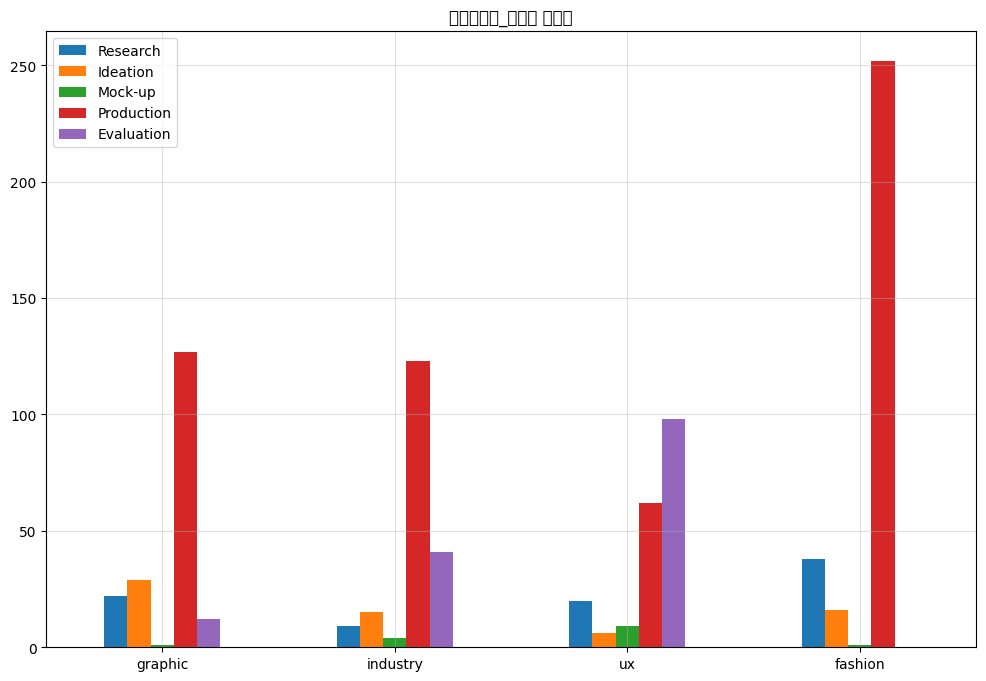

In [26]:
total.plot(kind='bar', rot=0)
plt.grid(True, alpha=0.4, zorder=0)
plt.title("빈도수분석_디자인 영역별")
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

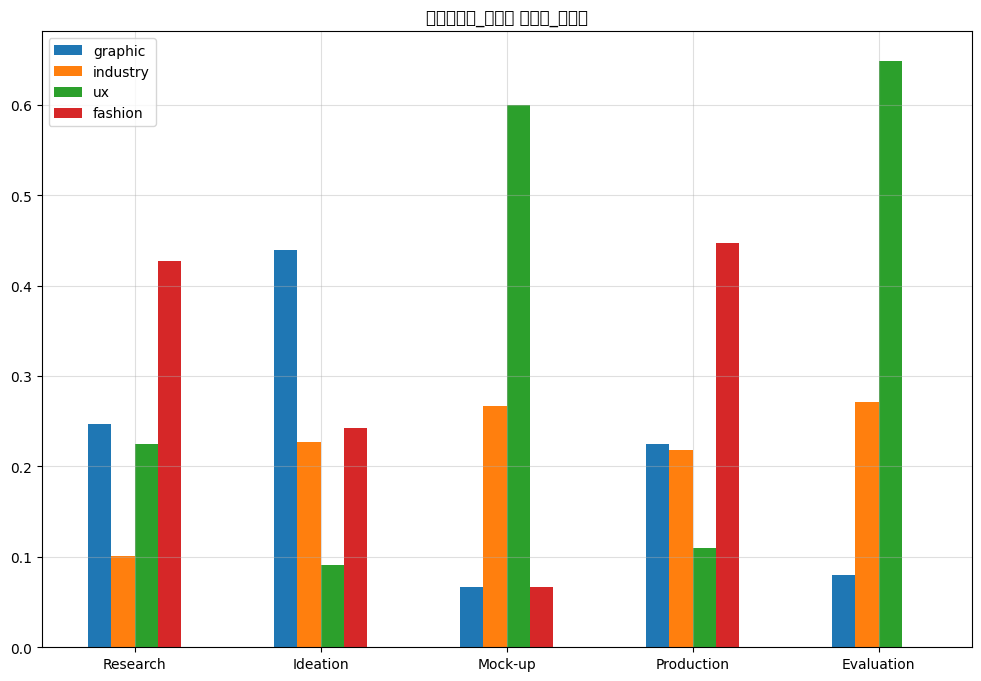

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

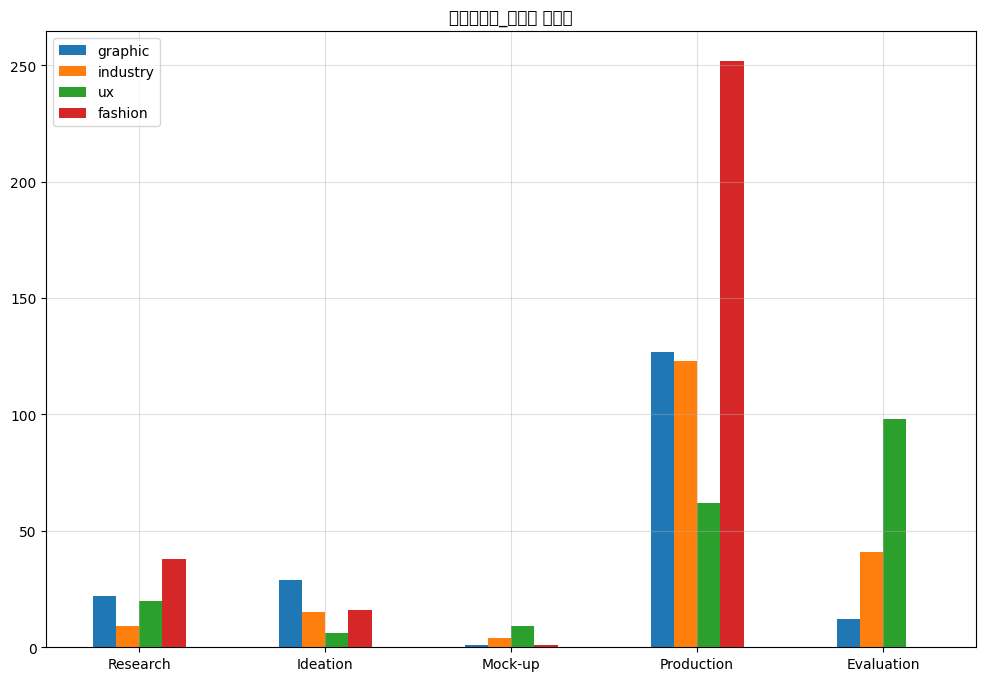

In [27]:
total_ratio = total.div(total.sum(), axis=1)
total_ratio_transposed = total_ratio.transpose()

total_ratio_transposed.plot(kind='bar', rot=0)
plt.grid(True, alpha=0.4, zorder=0)
plt.title("빈도수분석_디자인 단계별_비율화")
plt.legend(loc='upper left')
plt.show()

total_transposed.plot(kind='bar', rot=0)
plt.grid(True, alpha=0.4, zorder=0)
plt.title("빈도수분석_디자인 단계별")
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

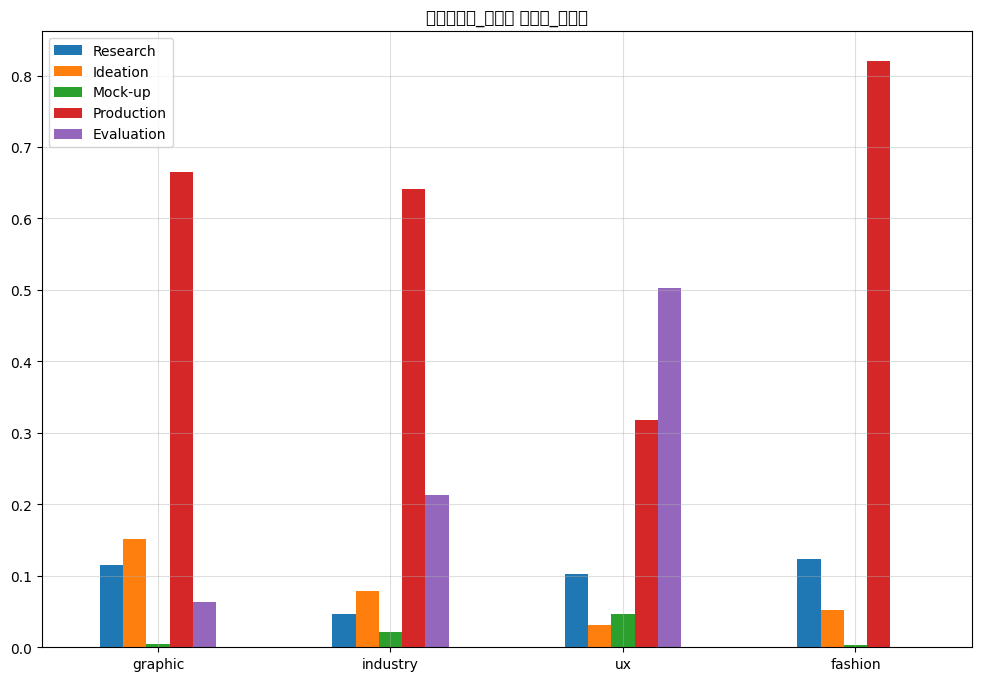

In [28]:
total_transposed_ratio = total_transposed.div(total_transposed.sum(), axis=1)
total_transposed_ratio_transposed = total_transposed_ratio.transpose()

total_transposed_ratio_transposed.plot(kind='bar', rot=0)
plt.grid(True, alpha=0.4, zorder=0)
plt.title("빈도수분석_디자인 영역별_비율화")
plt.legend(loc='upper left')
plt.show()

In [29]:
total_transposed_ratio_transposed

,Research,Ideation,Mock-up,Production,Evaluation
graphic,0.115183,0.151832,0.005236,0.664921,0.062827
industry,0.046875,0.078125,0.020833,0.640625,0.213542
ux,0.102564,0.030769,0.046154,0.317949,0.502564
fashion,0.123779,0.052117,0.003257,0.820847,0.000000


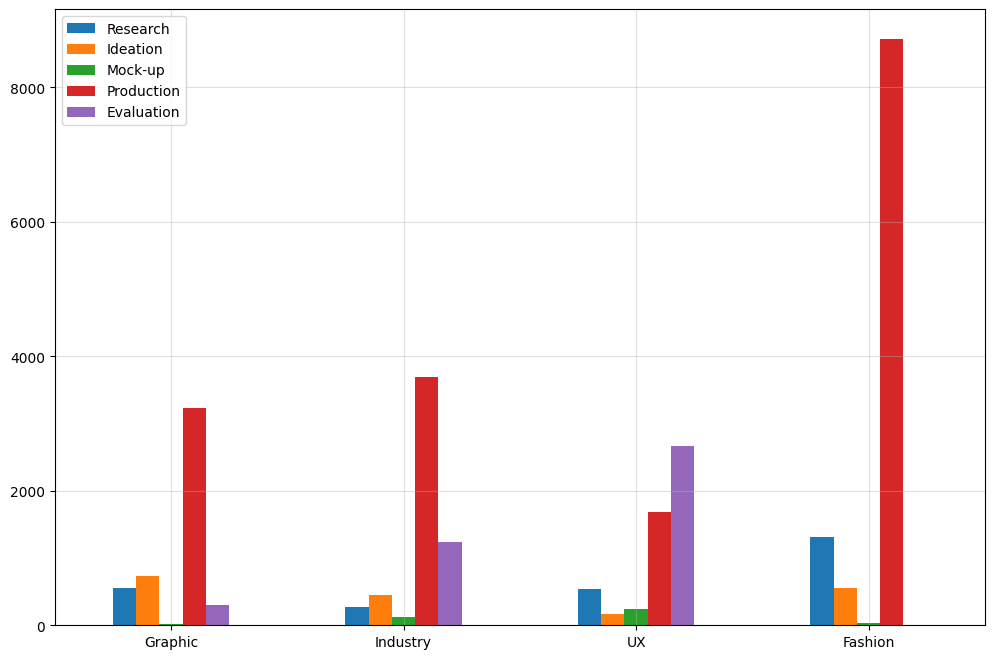

In [30]:
num_rows_crawled_graphic = len(df_crawled_graphic_k)
num_rows_crawled_industry = len(df_crawled_industry_k)
num_rows_crawled_ux = len(df_crawled_ux_k)
num_rows_crawled_fashion = len(df_crawled_fashion_k)

df_total_standard_graphic = df_total_graphic.apply(lambda x: x/num_rows_crawled_graphic)
df_total_standard_industry = df_total_industry.apply(lambda x: x/num_rows_crawled_industry)
df_total_standard_fashion = df_total_fashion.apply(lambda x: x/num_rows_crawled_fashion)
df_total_standard_ux = df_total_ux.apply(lambda x: x/num_rows_crawled_ux)

total_standard = pd.concat([df_total_standard_graphic, df_total_standard_industry, df_total_standard_ux, df_total_standard_fashion], join='outer', axis=0, ignore_index=True)
total_standard.index = ['Graphic', 'Industry', 'UX', 'Fashion']
total_standard_2 = (total_standard * 1000000).round(0).astype(int)
total_standard_2

total_standard_2.plot(kind='bar', rot=0)
plt.grid(True, alpha=0.4, zorder=0)
plt.legend(loc='best')
plt.show()

Standardization

In [33]:
total

,Research,Ideation,Mock-up,Production,Evaluation
graphic,22.0,29.0,1.0,127.0,12.0
industry,9.0,15.0,4.0,123.0,41.0
ux,20.0,6.0,9.0,62.0,98.0
fashion,38.0,16.0,1.0,252.0,0.0


In [32]:
index = ['Graphic', 'Industry', 'UX', 'Fashion']

In [ ]:
# 값 입력

results = pd.DataFrame({'Research':[560, 271, 544, 1315], 'Ideation': [738, 451, 163, 554],
                       'Mock-up': [25, 120, 245, 35], 'Production': [3232, 3697, 1687, 8724],
                       'Evaluation': [305, 1232, 2667, 0]}, index = index)
results

,Research,Ideation,Mock-up,Production,Evaluation
Graphic,560,738,25,3232,305
Industry,271,451,120,3697,1232
UX,544,163,245,1687,2667
Fashion,1315,554,35,8724,0


In [ ]:
# Visual Python: Data Analysis > Snippets
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")


Saving Data Analysis_Revised_v1_Topic Modeiling_v3.ipynb to Data Analysis_Revised_v1_Topic Modeiling_v3.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>